In [1]:
# Block 1: Improved Imports and Configuration
#-----------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
from PIL import Image
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, UpSampling2D, Concatenate, Input, 
    MaxPooling2D, Flatten, BatchNormalization, Reshape, GlobalAveragePooling2D,
    Add, Lambda, ZeroPadding2D
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.utils import plot_model
from typing import Tuple, List
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define paths for images and labels
TRAIN_IMAGE_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/images/train"
TRAIN_LABEL_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/labels/train"
VAL_IMAGE_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/images/val"
VAL_LABEL_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/labels/val"

# Improved model and training configurations
IMAGE_SIZE = (416, 416)  # Reduced for memory efficiency
BATCH_SIZE = 8  # Reduced for 16GB GPU
NUM_CLASSES = 10
NUM_ANCHORS = 3
EPOCHS = 50  # Reduced epochs
LEARNING_RATE = 2e-4
CONFIDENCE_THRESHOLD = 0.5

# Class names for visualization
CLASS_NAMES = [
    'XR_ELBOW_positive', 'XR_FINGER_positive', 'XR_FOREARM_positive',
    'XR_HAND_positive', 'XR_SHOULDER_positive',
    'XR_ELBOW_negative', 'XR_FINGER_negative', 'XR_FOREARM_negative',
    'XR_HAND_negative', 'XR_SHOULDER_negative'
]

print("Configuration loaded successfully!")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}") 

2025-08-01 07:35:02.929243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754033703.172159      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754033703.241607      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Configuration loaded successfully!
Image size: (416, 416)
Batch size: 8
Learning rate: 0.0002


In [2]:
#-----------------------------------------------------------
# Cell 2: Enhanced Data Loading and Processing Functions
#-----------------------------------------------------------

def create_dataset_with_labels(image_dir: str, label_dir: str) -> List[dict]:
    """Creates a dataset by pairing images with their corresponding labels."""
    image_paths = glob.glob(os.path.join(image_dir, '*.png'))
    dataset = []
    missing_labels_count = 0
    invalid_labels_count = 0
    
    for image_path in tqdm(image_paths, desc="Loading dataset"):
        label_filename = os.path.basename(image_path).replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_filename)
        
        if os.path.exists(label_path):
            try:
                with open(label_path, 'r') as file:
                    labels = file.readlines()
                
                valid_labels = []
                for label in labels:
                    parts = label.strip().split()
                    if len(parts) == 5:
                        class_id = int(float(parts[0]))
                        if 0 <= class_id < NUM_CLASSES:
                            valid_labels.append(label)
                        else:
                            invalid_labels_count += 1
                
                if valid_labels:
                    dataset.append({'image_path': image_path, 'labels': valid_labels})
                else:
                    missing_labels_count += 1
                    
            except Exception as e:
                print(f"Error reading {label_path}: {e}")
                missing_labels_count += 1
        else:
            missing_labels_count += 1
            
    print(f"Total images found: {len(image_paths)}")
    print(f"Images with valid labels: {len(dataset)}")
    print(f"Images skipped: {missing_labels_count + invalid_labels_count}")
    return dataset

def advanced_augmentation(image, labels):
    """Advanced augmentation for X-ray images."""
    h, w = image.shape[:2]
    
    # Random horizontal flip
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        new_labels = []
        for label in labels:
            parts = label.strip().split()
            class_id = parts[0]
            x_center, y_center, width, height = map(float, parts[1:])
            x_center = 1.0 - x_center  # Flip x coordinate
            new_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")
        labels = new_labels
    
    # Random rotation (small angles for medical images)
    if random.random() > 0.7:
        angle = random.uniform(-10, 10)
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, matrix, (w, h), borderValue=(0, 0, 0))
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    if random.random() > 0.5:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = clahe.apply(image)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image = clahe.apply(image)
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Random brightness and contrast
    if random.random() > 0.5:
        alpha = random.uniform(0.8, 1.2)  # Contrast
        beta = random.uniform(-20, 20)    # Brightness
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    # Gaussian noise
    if random.random() > 0.8:
        noise = np.random.normal(0, 0.1, image.shape).astype(np.float32)
        image = image.astype(np.float32) / 255.0
        image = np.clip(image + noise, 0, 1)
        image = (image * 255).astype(np.uint8)
    
    return image, labels

def enhanced_data_generator(dataset: List[dict], batch_size: int, image_size: Tuple[int, int], 
                           num_classes: int, num_anchors: int, augment: bool = True, 
                           class_weights: dict = None):
    """Enhanced generator with better augmentation and class balancing."""
    while True:
        if augment:
            random.shuffle(dataset)
        
        for i in range(0, len(dataset), batch_size):
            batch_data = dataset[i:i+batch_size]
            
            images = np.zeros((len(batch_data), *image_size, 3), dtype=np.float32)
            class_labels = np.zeros((len(batch_data), num_classes), dtype=np.float32)
            bbox_labels = np.zeros((len(batch_data), num_classes, 4), dtype=np.float32)
            objectness_labels = np.zeros((len(batch_data), num_anchors), dtype=np.float32)

            for j, data in enumerate(batch_data):
                try:
                    # Load image
                    image = cv2.imread(data['image_path'])
                    if image is None:
                        continue
                    
                    # Apply augmentation if training
                    if augment:
                        image, data['labels'] = advanced_augmentation(image, data['labels'])
                    
                    # Resize and normalize
                    image = cv2.resize(image, image_size)
                    image = image.astype(np.float32) / 255.0
                    images[j] = image
                    
                    # Process labels
                    for label_line in data['labels']:
                        parts = list(map(float, label_line.strip().split()))
                        class_id = int(parts[0])
                        x_center, y_center, width, height = parts[1:]
                        
                        # Ensure coordinates are within bounds
                        x_center = np.clip(x_center, 0, 1)
                        y_center = np.clip(y_center, 0, 1)
                        width = np.clip(width, 0, 1)
                        height = np.clip(height, 0, 1)
                        
                        if class_id < num_classes:
                            class_labels[j, class_id] = 1
                            bbox_labels[j, class_id] = [x_center, y_center, width, height]
                    
                    # Set objectness
                    if np.any(class_labels[j] > 0):
                        objectness_labels[j, :] = 1.0

                except Exception as e:
                    print(f"Error processing {data['image_path']}: {e}")
                    continue
            
            yield images, (class_labels, bbox_labels, objectness_labels)

# Load datasets
print("--- Processing Training Data ---")
train_dataset = create_dataset_with_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
print("\n--- Processing Validation Data ---")
val_dataset = create_dataset_with_labels(VAL_IMAGE_DIR, VAL_LABEL_DIR)

--- Processing Training Data ---


Loading dataset: 100%|██████████| 23851/23851 [01:26<00:00, 276.33it/s]


Total images found: 23851
Images with valid labels: 20501
Images skipped: 3350

--- Processing Validation Data ---


Loading dataset: 100%|██████████| 1000/1000 [00:03<00:00, 253.78it/s]

Total images found: 1000
Images with valid labels: 1000
Images skipped: 0



=== COMPREHENSIVE EXPLORATORY DATA ANALYSIS ===

Dataset Overview:
Training samples: 20501
Validation samples: 1000


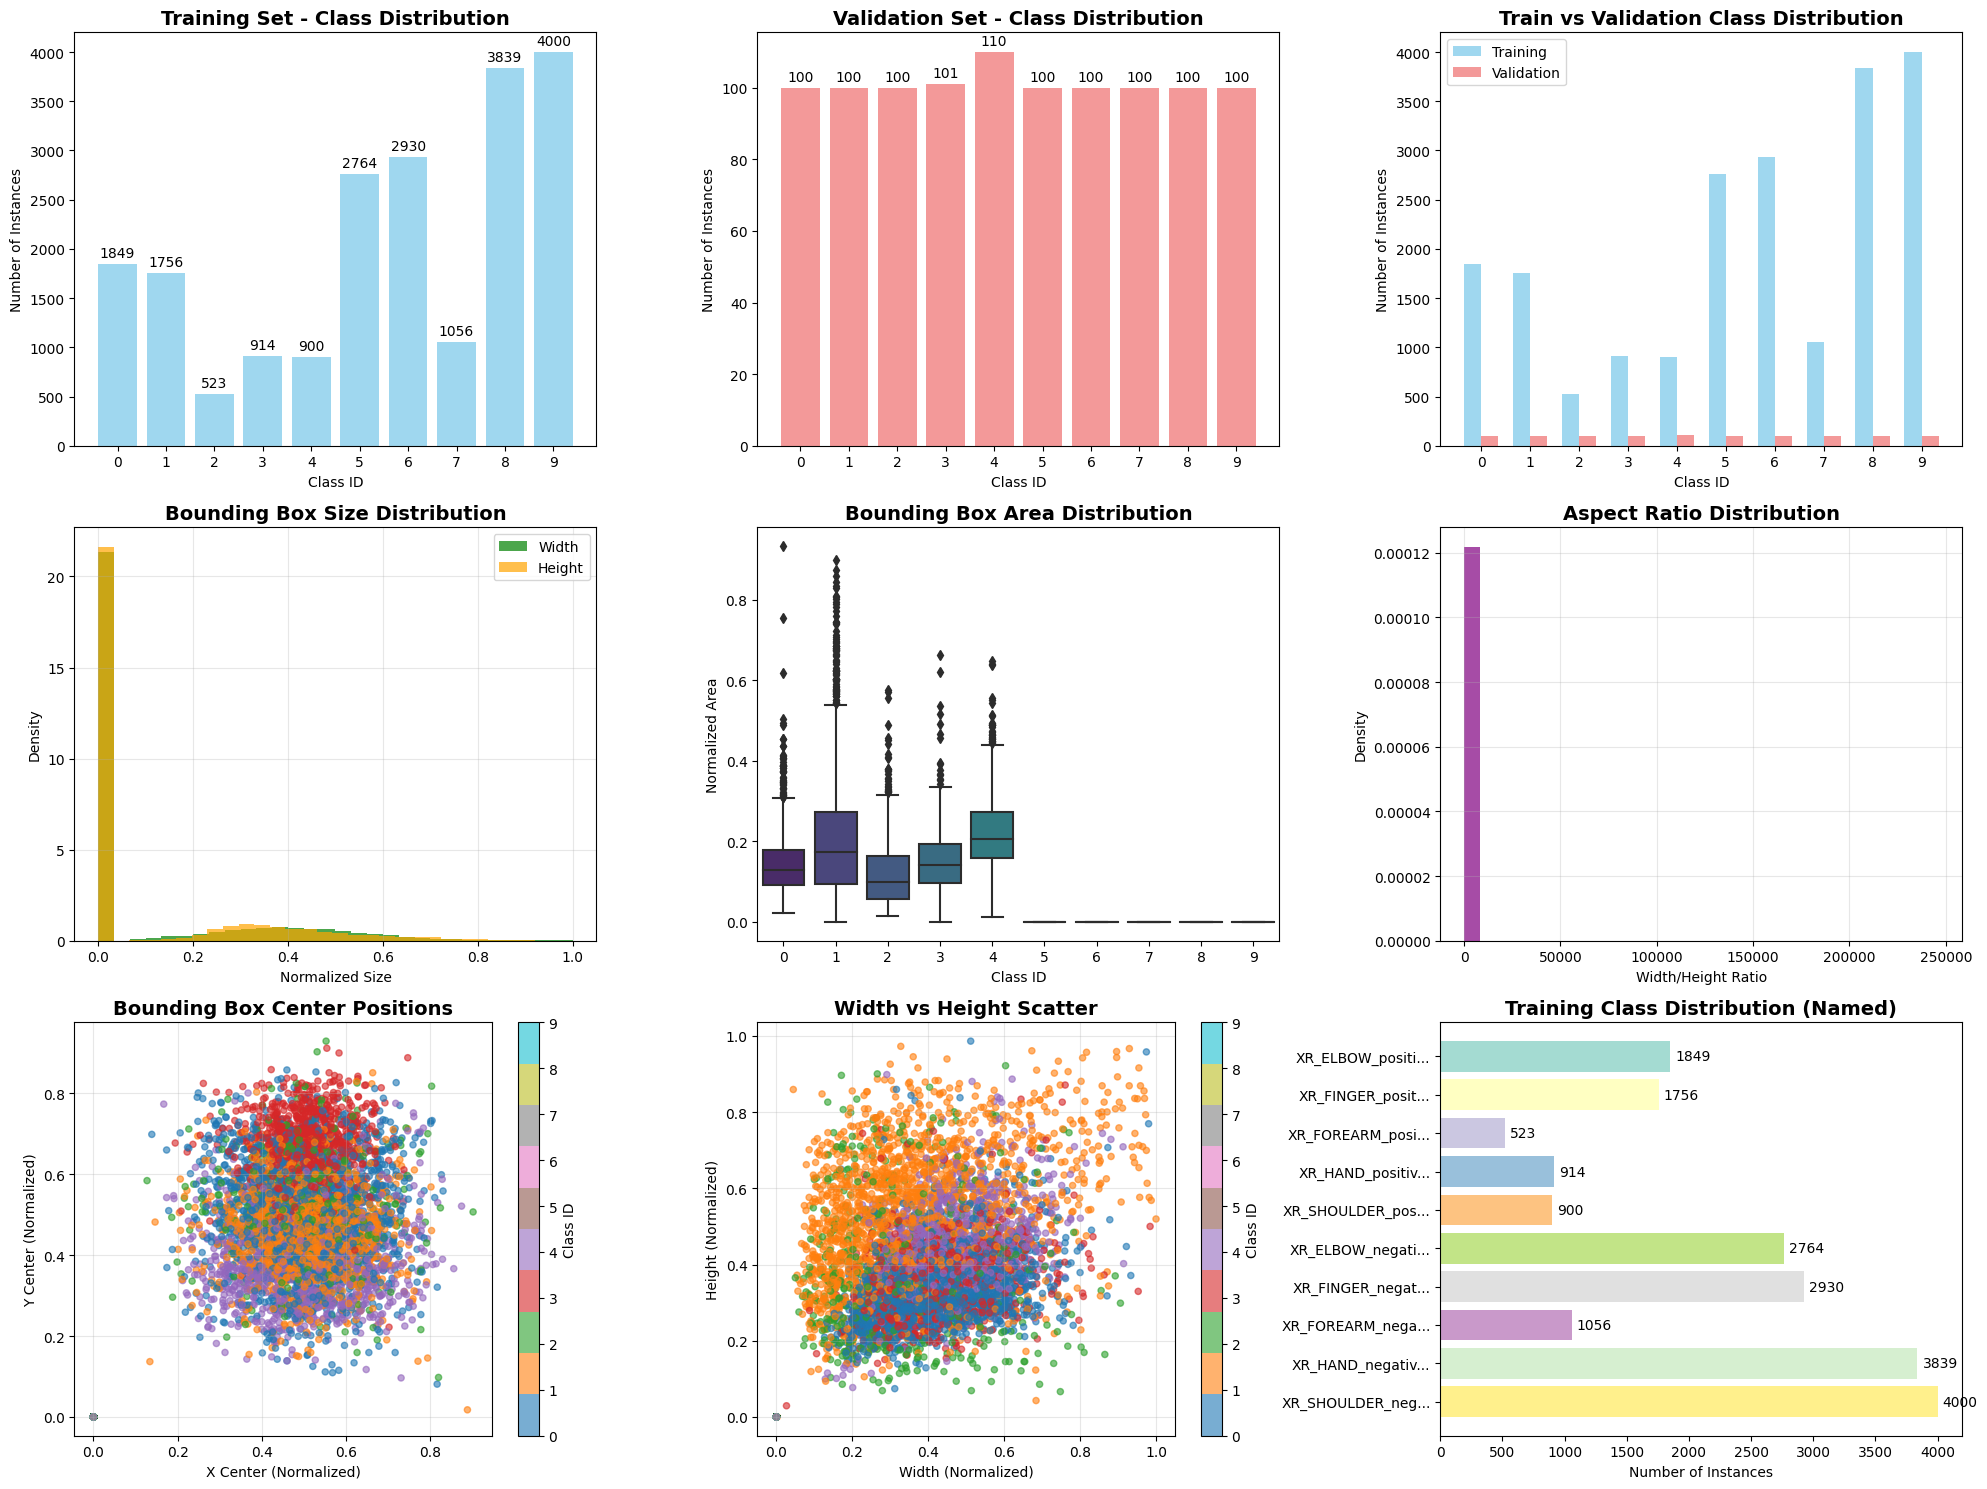


=== DETAILED STATISTICS ===

Class distribution analysis:
Class Name                      Train    Val    Train%   Val%  
----------------------------------------------------------------------
0   XR_ELBOW_positive         1849     100    9.0    % 9.9  %
1   XR_FINGER_positive        1756     100    8.6    % 9.9  %
2   XR_FOREARM_positive       523      100    2.5    % 9.9  %
3   XR_HAND_positive          914      101    4.5    % 10.0 %
4   XR_SHOULDER_positive      900      110    4.4    % 10.9 %
5   XR_ELBOW_negative         2764     100    13.5   % 9.9  %
6   XR_FINGER_negative        2930     100    14.3   % 9.9  %
7   XR_FOREARM_negative       1056     100    5.1    % 9.9  %
8   XR_HAND_negative          3839     100    18.7   % 9.9  %
9   XR_SHOULDER_negative      4000     100    19.5   % 9.9  %

Total training instances: 20531
Total validation instances: 1011

=== RECOMMENDED CLASS WEIGHTS ===
Class 0 (XR_ELBOW_positive): 2.16
Class 1 (XR_FINGER_positive): 2.28
Class 2 (XR_FORE

In [3]:
#-----------------------------------------------------------
# Cell 3: Comprehensive Exploratory Data Analysis (EDA)
#-----------------------------------------------------------

def perform_comprehensive_eda(train_dataset, val_dataset):
    """Comprehensive EDA for the X-ray fracture dataset."""
    print("\n=== COMPREHENSIVE EXPLORATORY DATA ANALYSIS ===")
    
    # 1. Dataset Overview
    print(f"\nDataset Overview:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # 2. Extract class information
    def extract_class_info(dataset):
        class_counts = {}
        bbox_info = []
        
        for data in dataset:
            for label in data['labels']:
                parts = label.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_c, y_c, w, h = map(float, parts[1:])
                    
                    class_counts[class_id] = class_counts.get(class_id, 0) + 1
                    bbox_info.append({
                        'class_id': class_id,
                        'x_center': x_c,
                        'y_center': y_c,
                        'width': w,
                        'height': h,
                        'area': w * h
                    })
        
        return class_counts, bbox_info
    
    train_class_counts, train_bbox_info = extract_class_info(train_dataset)
    val_class_counts, val_bbox_info = extract_class_info(val_dataset)
    
    # 3. Visualization
    plt.figure(figsize=(20, 15))
    
    # Training set class distribution
    plt.subplot(3, 3, 1)
    classes = list(range(NUM_CLASSES))
    train_counts = [train_class_counts.get(i, 0) for i in classes]
    bars = plt.bar(classes, train_counts, color='skyblue', alpha=0.8)
    plt.title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Instances')
    plt.xticks(classes)
    
    # Add value labels on bars
    for bar, count in zip(bars, train_counts):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(train_counts)*0.01, 
                    str(count), ha='center', va='bottom', fontsize=10)
    
    # Validation set class distribution
    plt.subplot(3, 3, 2)
    val_counts = [val_class_counts.get(i, 0) for i in classes]
    bars = plt.bar(classes, val_counts, color='lightcoral', alpha=0.8)
    plt.title('Validation Set - Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Instances')
    plt.xticks(classes)
    
    for bar, count in zip(bars, val_counts):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(val_counts)*0.01, 
                    str(count), ha='center', va='bottom', fontsize=10)
    
    # Combined class distribution comparison
    plt.subplot(3, 3, 3)
    x = np.arange(NUM_CLASSES)
    width = 0.35
    plt.bar(x - width/2, train_counts, width, label='Training', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, val_counts, width, label='Validation', alpha=0.8, color='lightcoral')
    plt.title('Train vs Validation Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Instances')
    plt.xticks(x)
    plt.legend()
    
    # Only proceed with bbox analysis if we have data
    if train_bbox_info:
        train_bbox_df = pd.DataFrame(train_bbox_info)
        
        # Bounding box size distribution
        plt.subplot(3, 3, 4)
        plt.hist(train_bbox_df['width'], bins=30, alpha=0.7, label='Width', color='green', density=True)
        plt.hist(train_bbox_df['height'], bins=30, alpha=0.7, label='Height', color='orange', density=True)
        plt.title('Bounding Box Size Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Normalized Size')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Box area by class
        plt.subplot(3, 3, 5)
        if len(train_bbox_df['class_id'].unique()) > 1:
            sns.boxplot(data=train_bbox_df, x='class_id', y='area', palette='viridis')
        else:
            plt.hist(train_bbox_df['area'], bins=20, alpha=0.7, color='purple')
        plt.title('Bounding Box Area Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Class ID' if len(train_bbox_df['class_id'].unique()) > 1 else 'Area')
        plt.ylabel('Normalized Area')
        
        # Aspect ratio analysis
        train_bbox_df['aspect_ratio'] = train_bbox_df['width'] / (train_bbox_df['height'] + 1e-8)
        plt.subplot(3, 3, 6)
        plt.hist(train_bbox_df['aspect_ratio'], bins=30, alpha=0.7, color='purple', density=True)
        plt.title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Width/Height Ratio')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
        
        # Center position scatter
        plt.subplot(3, 3, 7)
        scatter = plt.scatter(train_bbox_df['x_center'], train_bbox_df['y_center'], 
                   c=train_bbox_df['class_id'], cmap='tab10', alpha=0.6, s=20)
        plt.title('Bounding Box Center Positions', fontsize=14, fontweight='bold')
        plt.xlabel('X Center (Normalized)')
        plt.ylabel('Y Center (Normalized)')
        plt.colorbar(scatter, label='Class ID')
        plt.grid(True, alpha=0.3)
        
        # Width vs Height scatter
        plt.subplot(3, 3, 8)
        plt.scatter(train_bbox_df['width'], train_bbox_df['height'], 
                   c=train_bbox_df['class_id'], cmap='tab10', alpha=0.6, s=20)
        plt.title('Width vs Height Scatter', fontsize=14, fontweight='bold')
        plt.xlabel('Width (Normalized)')
        plt.ylabel('Height (Normalized)')
        plt.colorbar(label='Class ID')
        plt.grid(True, alpha=0.3)
    
    # Class names with counts
    plt.subplot(3, 3, 9)
    class_names_short = [name[:15] + '...' if len(name) > 15 else name for name in CLASS_NAMES]
    colors = plt.cm.Set3(np.linspace(0, 1, NUM_CLASSES))
    plt.barh(range(NUM_CLASSES), train_counts, color=colors, alpha=0.8)
    plt.title('Training Class Distribution (Named)', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Instances')
    plt.yticks(range(NUM_CLASSES), class_names_short)
    plt.gca().invert_yaxis()
    
    # Add count labels
    for i, count in enumerate(train_counts):
        if count > 0:
            plt.text(count + max(train_counts)*0.01, i, str(count), 
                    va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Detailed statistics
    print(f"\n=== DETAILED STATISTICS ===")
    total_train = sum(train_counts)
    total_val = sum(val_counts)
    
    print("\nClass distribution analysis:")
    print(f"{'Class':<3} {'Name':<25} {'Train':<8} {'Val':<6} {'Train%':<8} {'Val%':<6}")
    print("-" * 70)
    
    for i in range(NUM_CLASSES):
        train_count = train_counts[i]
        val_count = val_counts[i]
        train_pct = (train_count / total_train * 100) if total_train > 0 else 0
        val_pct = (val_count / total_val * 100) if total_val > 0 else 0
        
        print(f"{i:<3} {CLASS_NAMES[i][:24]:<25} {train_count:<8} {val_count:<6} "
              f"{train_pct:<7.1f}% {val_pct:<5.1f}%")
    
    print(f"\nTotal training instances: {total_train}")
    print(f"Total validation instances: {total_val}")
    
    # 5. Calculate class weights for imbalanced dataset
    if train_counts and max(train_counts) > 0:
        max_count = max(train_counts)
        class_weights = {i: max_count / max(count, 1) for i, count in enumerate(train_counts)}
        
        print(f"\n=== RECOMMENDED CLASS WEIGHTS ===")
        for i, weight in class_weights.items():
            print(f"Class {i} ({CLASS_NAMES[i][:20]}): {weight:.2f}")
        
        return class_weights
    
    return None

# Run EDA
class_weights = perform_comprehensive_eda(train_dataset, val_dataset)

In [6]:
# Block 3: Improved Model Architecture
#-----------------------------------------------------------
def residual_block(x, filters, kernel_size=3):
    """Residual block for better feature extraction."""
    shortcut = x
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def backbone_net(input_tensor: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """Improved backbone with residual connections."""
    # Initial convolution
    x = Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    c1 = x  # 1/4 scale
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    c2 = x  # 1/8 scale
    
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    c3 = x  # 1/16 scale
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    c4 = x  # 1/32 scale
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    c5 = x  # 1/64 scale
    
    return c3, c4, c5

def fpn(backbone_output: Tuple[tf.Tensor, tf.Tensor, tf.Tensor]) -> tf.Tensor:
    """Feature Pyramid Network with improved feature fusion."""
    c3, c4, c5 = backbone_output
    
    # Define a reusable Lambda layer for resizing to prevent shape mismatches.
    def resize_like(inputs):
        source, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(source, target_shape)

    # Top-down pathway
    P5 = Conv2D(256, 1, padding='same')(c5)
    P5_upsampled = UpSampling2D(size=(2, 2))(P5)
    
    P4 = Conv2D(256, 1, padding='same')(c4)
    
    # Use the Lambda layer to resize P5_upsampled to match P4's shape
    P5_resized = Lambda(resize_like)([P5_upsampled, P4])
    
    P4 = Add()([P4, P5_resized])
    P4 = Conv2D(256, 3, padding='same')(P4)
    P4_upsampled = UpSampling2D(size=(2, 2))(P4)
    
    P3 = Conv2D(256, 1, padding='same')(c3)
    
    # Use the Lambda layer again for robustness
    P4_resized = Lambda(resize_like)([P4_upsampled, P3])
    
    P3 = Add()([P3, P4_resized])
    P3 = Conv2D(256, 3, padding='same')(P3)
    
    return P3

def detection_head(input_tensor: tf.Tensor, num_classes: int, num_anchors: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """Improved detection head with better feature processing."""
    # Global context
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Classification branch
    class_branch = Dense(256, activation='relu')(x)
    class_output = Dense(num_classes, activation='sigmoid', name='class_output')(class_branch)
    
    # Bounding box regression branch
    bbox_branch = Dense(256, activation='relu')(x)
    bbox_output = Dense(num_classes * 4, activation='sigmoid', name='bbox_output')(bbox_branch)
    bbox_output = Reshape((num_classes, 4), name='reshape_bboxes')(bbox_output)
    
    # Objectness branch
    obj_branch = Dense(128, activation='relu')(x)
    objectness_output = Dense(num_anchors, activation='sigmoid', name='objectness_output')(obj_branch)
    
    return class_output, bbox_output, objectness_output

def build_model(image_size: Tuple[int, int], num_classes: int, num_anchors: int) -> Model:
    """Builds and compiles the improved model."""
    inputs = Input(shape=(*image_size, 3))
    
    backbone_features = backbone_net(inputs)
    fpn_features = fpn(backbone_features)
    class_out, bbox_out, obj_out = detection_head(fpn_features, num_classes, num_anchors)
    
    model = Model(inputs=inputs, outputs=[class_out, bbox_out, obj_out])
    
    # Custom loss weights for better balance
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'class_output': 'binary_crossentropy',
            'reshape_bboxes': 'mean_squared_error',
            'objectness_output': 'binary_crossentropy'
        },
        loss_weights={
            'class_output': 1.0,
            'reshape_bboxes': 2.0,
            'objectness_output': 0.5
        },
        metrics={
            'class_output': 'accuracy',
            'reshape_bboxes': 'mse'
        }
    )
    
    return model

In [ ]:
# Block 4: Improved Training Setup
#-----------------------------------------------------------

# Set up GPU strategy with memory management
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f"--- Running on {strategy.num_replicas_in_sync} GPUs. ---")
except Exception as e:
    print(f"--- GPU setup failed, running on default strategy. Error: {e} ---")
    strategy = tf.distribute.get_strategy()

# Build and compile the model within the strategy scope
with strategy.scope():
    model = build_model(IMAGE_SIZE, NUM_CLASSES, NUM_ANCHORS)

print("Model Summary:")
model.summary()

# --- FIX STARTS HERE ---
# Instantiate the data generators using the function from Cell 2
print("\n--- Creating Data Generators ---")
train_data_gen = enhanced_data_generator(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_classes=NUM_CLASSES,
    num_anchors=NUM_ANCHORS,
    augment=True,
    class_weights=class_weights
)

val_data_gen = enhanced_data_generator(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_classes=NUM_CLASSES,
    num_anchors=NUM_ANCHORS,
    augment=False  # Augmentation should be disabled for validation
)
# --- FIX ENDS HERE ---

# Define improved callbacks
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1,
    save_weights_only=False
)

early_stopping = EarlyStopping(
    patience=15,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Calculate steps per epoch
steps_per_epoch = len(train_dataset) // BATCH_SIZE
validation_steps = len(val_dataset) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
print("\n--- Starting Improved Model Training ---")
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint, early_stopping, reduce_lr],
    verbose=1
)

# Save the final model
print("\n--- Saving final model ---")
model.save('/kaggle/working/final_model.keras')

print("--- Training finished successfully. ---")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['reshape_bboxes_mse'], label='Training MSE')
plt.plot(history.history['val_reshape_bboxes_mse'], label='Validation MSE')
plt.title('Bounding Box MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

--- Running on 1 GPUs. ---
Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 208, 208,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 208, 208,  │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 208, 208,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 104, 104,  │          0 │ re_lu_25[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 104, 104,  │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 104, 104,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 104, 104,  │     36,928 │ re_lu_26[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 104, 104,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 104, 104,  │          0 │ add_14[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 104, 104,  │     36,928 │ re_lu_27[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 104, 104,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 104, 104,  │     36,928 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_38[0][0] 

 Total params: 34,463,157 (131.47 MB)

 Trainable params: 34,448,181 (131.41 MB)

 Non-trainable params: 14,976 (58.50 KB)


--- Creating Data Generators ---
Steps per epoch: 2562
Validation steps: 125

--- Starting Improved Model Training ---
Epoch 1/50


I0000 00:00:1754034366.424339      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  11/2562 ━━━━━━━━━━━━━━━━━━━━ 5:59 141ms/step - class_output_accuracy: 0.0541 - class_output_loss: 0.7675 - loss: 1.4361 - objectness_output_loss: 0.3737 - reshape_bboxes_loss: 0.2409 - reshape_bboxes_mse: 0.2409

In [ ]:
# Block 5: Improved Evaluation
#-----------------------------------------------------------
def load_and_evaluate_model():
    """Load the best model and evaluate it."""
    print("\n--- Loading Best Model for Evaluation ---")
    
    strategy = tf.distribute.MirroredStrategy()
    model_path = '/kaggle/working/best_model.keras'
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    with strategy.scope():
        model = load_model(model_path)
    
    print("Model loaded successfully!")
    return model

def get_predictions_and_truths_improved(model, dataset):
    """Improved prediction generation with better handling."""
    all_predictions = []
    all_ground_truths = []
    
    for item in tqdm(dataset, desc="Generating Predictions"):
        try:
            # Load and preprocess the image
            image = cv2.imread(item['image_path'])
            if image is None:
                continue
                
            image_resized = cv2.resize(image, IMAGE_SIZE)
            image_normalized = image_resized / 255.0
            image_batch = np.expand_dims(image_normalized, axis=0)
            
            # Get model predictions
            class_pred, bbox_pred, obj_pred = model.predict(image_batch, verbose=0)
            
            # Store predictions
            all_predictions.append({
                'class': class_pred[0],
                'bbox': bbox_pred[0],
                'objectness': obj_pred[0]
            })
            
            # Store ground truth labels
            ground_truths = []
            for label_line in item['labels']:
                parts = list(map(float, label_line.strip().split()))
                class_id = int(parts[0])
                x_center, y_center, width, height = parts[1:]
                
                # Convert to [x_min, y_min, x_max, y_max] format
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                
                ground_truths.append({
                    'class_id': class_id, 
                    'bbox': [x_min, y_min, x_max, y_max]
                })
            all_ground_truths.append(ground_truths)
            
        except Exception as e:
            print(f"Error processing {item['image_path']}: {e}")
            continue
    
    return all_predictions, all_ground_truths

def calculate_iou_improved(box1, box2):
    """Calculate IoU with better numerical stability."""
    # box format: [x_min, y_min, x_max, y_max]
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])
    
    if x2_inter <= x1_inter or y2_inter <= y1_inter:
        return 0.0
    
    inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0

def evaluate_predictions_improved(predictions, ground_truths, iou_threshold=0.5, conf_threshold=0.5):
    """Improved evaluation with better multi-object handling."""
    y_true_classes = []
    y_pred_classes = []
    y_true_probs = []
    y_pred_probs = []
    
    for i in range(len(predictions)):
        pred = predictions[i]
        gts = ground_truths[i]
        
        # Get predicted class and confidence
        pred_class_probs = pred['class']
        pred_class_id = np.argmax(pred_class_probs)
        pred_confidence = pred_class_probs[pred_class_id]
        
        # Store probabilities for ROC analysis
        y_pred_probs.extend(pred_class_probs)
        
        if pred_confidence < conf_threshold:
            # Low confidence prediction - count as background
            for gt in gts:
                y_true_classes.append(gt['class_id'])
                y_pred_classes.append(-1)  # Background class
                y_true_probs.extend([0] * NUM_CLASSES)
            continue
        
        # Find best matching ground truth
        best_iou = 0
        best_gt_idx = -1
        pred_bbox = pred['bbox'][pred_class_id]
        
        for j, gt in enumerate(gts):
            iou = calculate_iou_improved(pred_bbox, gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        if best_iou > iou_threshold and best_gt_idx >= 0:
            # Good match
            matched_gt = gts[best_gt_idx]
            y_true_classes.append(matched_gt['class_id'])
            y_pred_classes.append(pred_class_id)
            y_true_probs.extend([1 if k == matched_gt['class_id'] else 0 for k in range(NUM_CLASSES)])
        else:
            # No good match - false positive
            y_true_classes.append(-1)  # Background
            y_pred_classes.append(pred_class_id)
            y_true_probs.extend([0] * NUM_CLASSES)
    
    return y_true_classes, y_pred_classes, y_true_probs, y_pred_probs

def run_evaluation():
    """Run the complete evaluation pipeline."""
    # Load model
    model = load_and_evaluate_model()
    
    # Generate predictions
    predictions, ground_truths = get_predictions_and_truths_improved(model, val_dataset)
    
    # Evaluate predictions
    y_true, y_pred, y_true_probs, y_pred_probs = evaluate_predictions_improved(
        predictions, ground_truths, iou_threshold=0.5, conf_threshold=0.5
    )
    
    # Filter out background predictions for class-specific metrics
    valid_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != -1]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]
    
    # Calculate metrics
    accuracy = sum(1 for true, pred in zip(y_true_filtered, y_pred_filtered) if true == pred) / len(y_true_filtered) if y_true_filtered else 0
    
    print(f"\n--- Evaluation Results ---")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Total Predictions: {len(y_true)}")
    print(f"Valid Predictions: {len(y_true_filtered)}")
    
    # Classification report
    if y_true_filtered:
        print("\n--- Classification Report ---")
        print(classification_report(
            y_true_filtered, 
            y_pred_filtered, 
            labels=range(NUM_CLASSES),
            target_names=CLASS_NAMES, 
            zero_division=0
        ))
    
    # Confusion matrix
    if y_true_filtered:
        cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=range(NUM_CLASSES))
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Confusion Matrix', fontsize=16)
        plt.ylabel('True Class', fontsize=12)
        plt.xlabel('Predicted Class', fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return model, accuracy

# Run evaluation if this block is executed
if __name__ == "__main__":
    run_evaluation() 

In [ ]:
#-----------------------------------------------------------
# Block 6: Model Loading and Verification
#-----------------------------------------------------------
print("\n--- Loading and Verifying The Best Saved Model ---")

# Define the same strategy used for training to ensure correct loading
strategy = tf.distribute.MirroredStrategy()

# CORRECTED: Define the path to the .keras model file
model_path = '/kaggle/working/best_model.keras'

print(f"--- Verifying existence of model file: {model_path} ---")
if os.path.exists(model_path):
    print("File found. Attempting to load.")
    try:
        # Load the model within the strategy scope
        with strategy.scope():
            loaded_model = load_model(model_path)
        
        print("\nSUCCESS: Model loaded successfully!")
        
        print("\n--- Loaded Model Summary ---")
        loaded_model.summary()

    except Exception as e:
        print(f"\nERROR: Model loading failed. Error: {e}")

else:
    print(f"FATAL ERROR: The model file '{model_path}' does not exist!")

In [ ]:
#-----------------------------------------------------------
# Block 1: Imports and Configuration
#-----------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import random
from PIL import Image
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, UpSampling2D, Concatenate, Input, 
    MaxPooling2D, Flatten, BatchNormalization, Reshape, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.utils import plot_model
from typing import Tuple, List
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm # For a nice progress bar
# Define paths for images and labels
# --- Make sure these paths are correct for your environment ---
TRAIN_IMAGE_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/images/train"
TRAIN_LABEL_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/labels/train"
VAL_IMAGE_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/images/val"
VAL_LABEL_DIR = "/kaggle/input/xr-bones-dataset-for-bone-fracture-detection/YOLODataSet/labels/val"

# Model and training configurations
IMAGE_SIZE = (512,512)
BATCH_SIZE = 12
NUM_CLASSES = 10
NUM_ANCHORS = 3
EPOCHS = 100
LEARNING_RATE = 1e-4  # Slightly increased learning rate for potentially faster convergence
CONFIDENCE_THRESHOLD = 0.3

# Class names for visualization
CLASS_NAMES = [
    'XR_ELBOW_positive', 'XR_FINGER_positive', 'XR_FOREARM_positive',
    'XR_HAND_positive', 'XR_SHOULDER_positive',
    'XR_ELBOW_negative', 'XR_FINGER_negative', 'XR_FOREARM_negative',
    'XR_HAND_negative', 'XR_SHOULDER_negative'
]
# --- Load the Best Performing Model ---
print("--- Loading and Verifying The Best Saved Model ---")
strategy = tf.distribute.MirroredStrategy()
model_path = '/kaggle/working/best_model.keras' # IMPORTANT: Evaluate your best model

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please ensure training is complete.")

with strategy.scope():
    model = load_model(model_path)

print("\nSUCCESS: Model loaded successfully!")

# --- Prepare the validation/test dataset ---
# (Reusing the dataset creation function from your training script)
def create_dataset_with_labels(image_dir: str, label_dir: str) -> list:
    # This function should be the same as in your training script
    image_paths = glob.glob(os.path.join(image_dir, '*.png'))
    dataset = []
    for image_path in image_paths:
        label_filename = os.path.basename(image_path).replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_filename)
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                labels = file.readlines()
            if labels:
                dataset.append({'image_path': image_path, 'labels': labels})
    return dataset

print("\n--- Loading validation dataset for evaluation ---")
eval_dataset = create_dataset_with_labels(VAL_IMAGE_DIR, VAL_LABEL_DIR)

In [ ]:
#-----------------------------------------------------------
# Block 2: Generating Predictions
#-----------------------------------------------------------
def get_predictions_and_truths(model, dataset):
    """Iterate through the dataset and collect model predictions and ground truths."""
    all_predictions = []
    all_ground_truths = []

    for item in tqdm(dataset, desc="Generating Predictions"):
        # Load and preprocess the image
        image = cv2.imread(item['image_path'])
        image_resized = cv2.resize(image, IMAGE_SIZE)
        image_normalized = image_resized / 255.0
        image_batch = np.expand_dims(image_normalized, axis=0)

        # Get model predictions
        class_pred, bbox_pred, obj_pred = model.predict(image_batch, verbose=0)
        
        # Store predictions
        all_predictions.append({
            'class': class_pred[0],
            'bbox': bbox_pred[0],
            'objectness': obj_pred[0]
        })

        # Store ground truth labels
        ground_truths = []
        for label_line in item['labels']:
            parts = list(map(float, label_line.strip().split()))
            class_id = int(parts[0])
            # Bbox format: [xmin, ymin, xmax, ymax] in relative coords (0-1)
            x_c, y_c, w, h = parts[1:]
            x_min = x_c - w / 2
            y_min = y_c - h / 2
            x_max = x_c + w / 2
            y_max = y_c + h / 2
            ground_truths.append({'class_id': class_id, 'bbox': [x_min, y_min, x_max, y_max]})
        all_ground_truths.append(ground_truths)

    return all_predictions, all_ground_truths

predictions, ground_truths = get_predictions_and_truths(model, eval_dataset)

In [ ]:
#-----------------------------------------------------------
# Block 3: Core Evaluation Logic (Corrected)
#-----------------------------------------------------------
def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) for two bounding boxes."""
    # box format: [x_min, y_min, x_max, y_max]
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

def evaluate_predictions(predictions, ground_truths, iou_threshold=0.5, conf_threshold=0.3):
    """Evaluate predictions against ground truths."""
    y_true_classes = []
    y_pred_classes = []
    
    # Define a class index for "background" or false positives
    background_class_id = NUM_CLASSES 
    
    for i in range(len(predictions)):
        pred = predictions[i]
        gts = ground_truths[i]
        
        pred_class_id = np.argmax(pred['class'])
        pred_confidence = pred['class'][pred_class_id]
        
        if pred_confidence < conf_threshold:
            # If model is not confident, we can skip or count GTs as missed
            for gt in gts:
                # This makes the report more accurate by logging a "miss"
                y_true_classes.append(gt['class_id'])
                y_pred_classes.append(background_class_id) # Predicted nothing
            continue

        pred_bbox = pred['bbox'][pred_class_id]
        best_iou = 0
        best_gt_idx = -1
        for j, gt in enumerate(gts):
            iou = calculate_iou(pred_bbox, gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        if best_iou > iou_threshold:
            matched_gt = gts[best_gt_idx]
            y_true_classes.append(matched_gt['class_id'])
            y_pred_classes.append(pred_class_id)
        else:
            y_true_classes.append(background_class_id) # It was background
            y_pred_classes.append(pred_class_id) # But we predicted a class
    
    return y_true_classes, y_pred_classes

# Run evaluation
y_true, y_pred = evaluate_predictions(predictions, ground_truths)

# --- Define the full set of labels the report should expect ---
# This is the list of all possible class indices: [0, 1, 2, ..., 9]
all_possible_labels = np.arange(len(CLASS_NAMES))

# --- Classification Report ---
print("\n--- Classification Report ---")
# THE FIX: Add the `labels` parameter to ensure all 10 classes are included.
print(classification_report(
    y_true, 
    y_pred, 
    labels=all_possible_labels, 
    target_names=CLASS_NAMES, 
    zero_division=0
))

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# THE FIX: Also add the `labels` parameter here for consistency.
cm = confusion_matrix(y_true, y_pred, labels=all_possible_labels)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('True Class', fontsize=15)
plt.xlabel('Predicted Class', fontsize=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

#---------------------------------------------------------------------
# This block calculates the overall accuracy based on the evaluation lists.
# It assumes 'y_true' and 'y_pred' have been generated by the 
# 'evaluate_predictions' function in the previous step.
#---------------------------------------------------------------------

# Calculate the accuracy score
# This function directly compares each element in y_true to y_pred
# and calculates (number of correct matches) / (total number of items).
accuracy = accuracy_score(y_true, y_pred)

# Convert to percentage and print in a readable format
accuracy_percentage = accuracy * 100

print("\n--- Overall Model Performance ---")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")
print("---------------------------------")
print("\nNote: This accuracy score represents the percentage of predictions where the model's")
print("predicted class matched the true class, considering an IoU threshold of 0.5 for a")
print("bounding box to be considered a 'match'. It includes false positives and negatives")
print("in its calculation, which is why it may differ from individual class metrics.")